#  The Speed Dataers Capstone Project Code

A Project by: Bruno Stefoni, David Shimshoni, Harshanand Anandan, Nikki Gharachorloo, and Claire Saint-Donant

## Question 1

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dating_data = pd.read_csv("Speed Dating Data.csv",
                         encoding="ISO-8859-1")

Our questions do not vary by waves, so we are using the most data that we can (i.e. using all waves and only dropping missing value rows)

In [14]:
# get last and first dates for each iid

dating_data_order_min = dating_data[['iid', 'order']].groupby('iid').min()
dating_data_order_max = dating_data[['iid', 'order']].groupby('iid').max()

In [15]:
# number of unique iids
len(dating_data['iid'].unique())

551

In [16]:
dating_data = dating_data.merge(dating_data_order_min, how='left', on='iid', suffixes=('', '_min'))
dating_data = dating_data.merge(dating_data_order_max, how='left', on='iid', suffixes=('', '_max'))


In [36]:
first_dec = dating_data.loc[dating_data['order'] == dating_data['order_min']]
last_dec = dating_data.loc[dating_data['order'] == dating_data['order_max']]

In [37]:
first_dec = first_dec.loc[~first_dec['dec'].isna()]
last_dec = last_dec.loc[~last_dec['dec'].isna()]


In [41]:
a = len(first_dec[(first_dec['dec'] == 0)].index)
b = len(first_dec[(first_dec['dec'] == 1)].index)

c = len(last_dec[(last_dec['dec'] == 0)].index)
d = len(last_dec[(last_dec['dec'] == 1)].index)

print(a,b)
print(c,d)
contingency_table = np.array([[a,b],[c,d]])

276 275
302 249


In [42]:
from scipy import stats
stats.chi2_contingency(contingency_table)

(2.274062970495787,
 0.1315546143800287,
 1,
 array([[289., 262.],
        [289., 262.]]))

In [43]:
data_gender0 = dating_data.loc[dating_data['gender'] == 0]
data_gender1 = dating_data.loc[dating_data['gender'] == 1]

In [44]:
a = len(data_gender0[(data_gender0['dec'] == 0)].index)
b = len(data_gender0[(data_gender0['dec'] == 1)].index)

c = len(data_gender1[(data_gender1['dec'] == 0)].index)
d = len(data_gender1[(data_gender1['dec'] == 1)].index)

print(a,b)
print(c,d)
contingency_table = np.array([[a,b],[c,d]])

2655 1529
2205 1989


In [45]:
stats.chi2_contingency(contingency_table)

(101.35647890703936,
 7.683349889046882e-24,
 1,
 array([[2427.09954643, 1756.90045357],
        [2432.90045357, 1761.09954643]]))

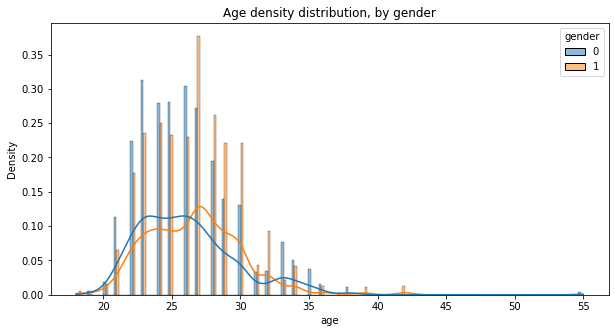

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(data=dating_data, x="age",
             kde=True, stat='density', hue="gender", 
             common_norm=False, multiple="dodge")
plt.title("Age density distribution, by gender")
plt.show()

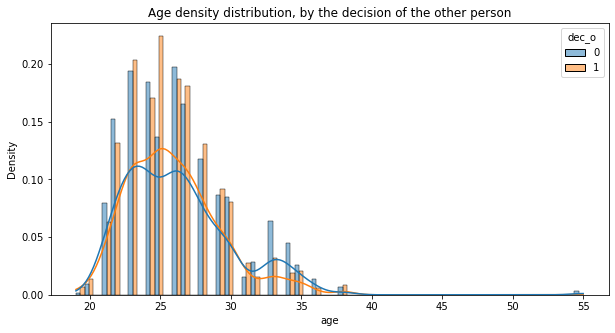

In [53]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data_gender0, x="age",
             kde=True, stat='density', hue="dec_o", 
             common_norm=False, multiple="dodge")
plt.title("Age density distribution, by the decision of the other person, females")
plt.show()

In [59]:
x1 = data_gender0.loc[data_gender0['dec_o']==0, 'age'].to_numpy()
x2 = data_gender0.loc[data_gender0['dec_o']==1, 'age'].to_numpy()
stats.kstest(x1,x2)

KstestResult(statistic=0.05161700603038375, pvalue=0.0073453166292272165)

In [61]:
x1 = data_gender1.loc[data_gender1['dec_o']==0, 'age'].to_numpy()
x2 = data_gender1.loc[data_gender1['dec_o']==1, 'age'].to_numpy()
stats.kstest(x1,x2)

KstestResult(statistic=0.032779643588557436, pvalue=0.24069266935942824)

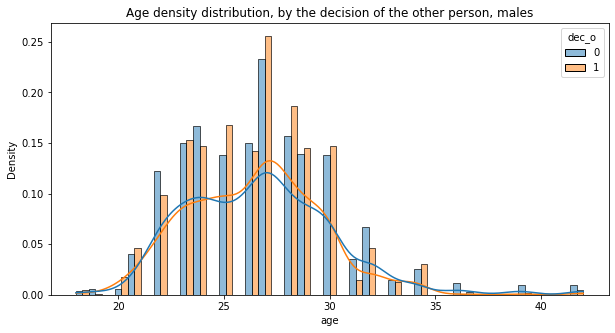

In [54]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data_gender1, x="age",
             kde=True, stat='density', hue="dec_o", 
             common_norm=False, multiple="dodge")
plt.title("Age density distribution, by the decision of the other person, males")
plt.show()

## Question 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

dating_data = pd.read_csv("Speed Dating Data.csv",
                         encoding="ISO-8859-1")
print(dating_data.shape)

(8378, 195)


From the Data Documentation, Waves 1-4, 10, 11, and 15-17 had the most common design, which had no variations in the pool of individuals, conditioning, and had the same preference scale, so we will filter the data to just those waves to find the significant correlations among the numerical columns to match.

As well, we will drop columns with more than 10% of entries missing, since we have no shortage of column and we will want to avoid columns with broad, systemic missing data

In [4]:
## waves with the most common experiment design
exp_waves = [1, 2, 3, 4, 10, 11, 15, 16, 17]

## filtering to data only from most common design waves
dating_df = dating_data.loc[dating_data.wave.isin(exp_waves)].copy()

## removing columns that are not relevant to these waves (i.e. all missing values in the filtered data)
dating_df = dating_df.dropna(axis=1, how='all')

## dropping columns that have more than 10% of entries missing
reduced_dating_df = dating_df.dropna(axis=1, thresh=math.floor(dating_df.shape[0]*0.9))
print(reduced_dating_df.shape)

(3760, 89)


Let's take a look now at the correlations among the numeric columns

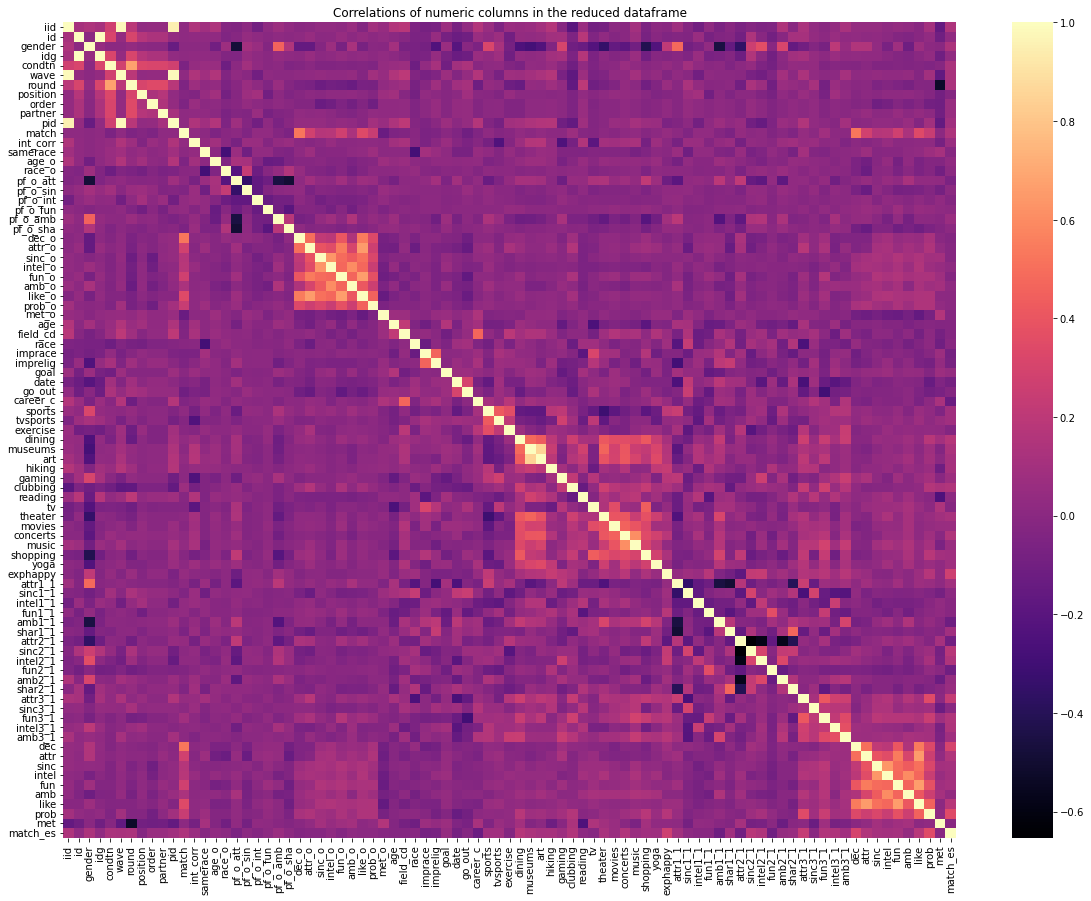

In [5]:
reduced_dating_df_numeric = reduced_dating_df.select_dtypes(np.number)

plt.figure(figsize=(20, 15))

## using Spearman correlation measure, since we've already seen non-normally distributed numeric data
corr = reduced_dating_df_numeric.corr(method='spearman')

sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           cmap='magma')
plt.title("Correlations of numeric columns in the reduced dataframe");

Now let's find the statistically significant correlations to match (setting $\alpha = 0.005$)

In [7]:
from scipy.stats import spearmanr

## list of significantly correlated columns, dropping missing values row-wise
sig_corr_columns = [col for col in corr.index 
                    if (spearmanr(reduced_dating_df.dropna(subset=['match', col]).match.values,
                                reduced_dating_df.dropna(subset=['match', col])[col].values)[1] <= 0.005)]
sig_corr_df = corr.loc[sig_corr_columns][sig_corr_columns]
print(f"Number of statistically significant columns: {sig_corr_df.shape[0]}")

Number of statistically significant columns: 31


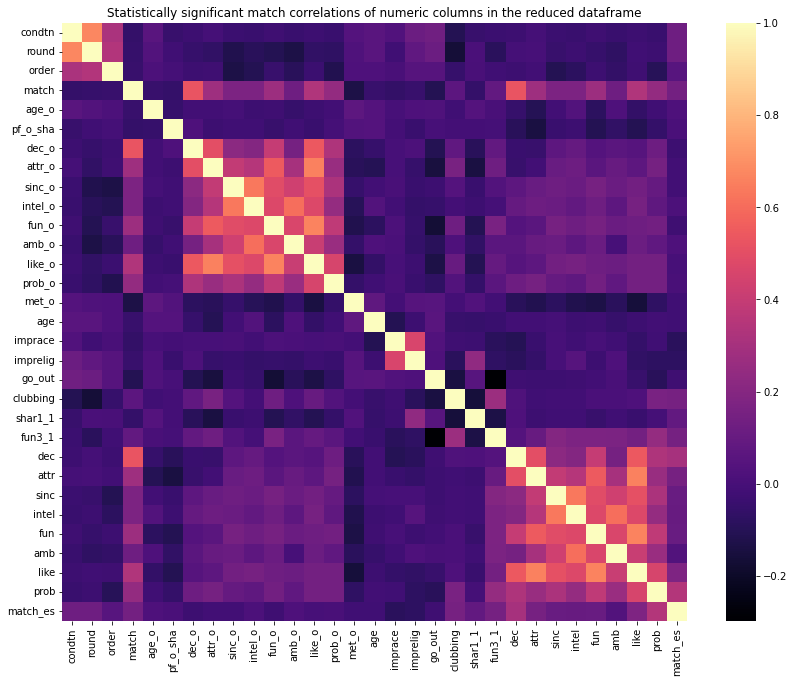

In [33]:
plt.figure(figsize=(14, 11))

sns.heatmap(sig_corr_df,
           xticklabels=sig_corr_df.columns.values,
           yticklabels=sig_corr_df.columns.values,
           cmap='magma')
plt.title("Statistically significant match correlations of numeric columns in the reduced dataframe")
plt.savefig('StatSigMatchCorr.png');

In [28]:
## dict of p-values of the correlations of numeric columns with match that aren't deterministically determinining match
col_corr_ps = {col: spearmanr(reduced_dating_df.dropna(subset=['match', col]).match.values,
                                reduced_dating_df.dropna(subset=['match', col])[col].values)[1]
            for col in corr.index
            if col not in ['dec', 'dec_o', 'match']}

## sorting col_corr_ps
sorted_corr_ps = sorted(col_corrs.items(), key=lambda x: x[1], reverse=False)

In [35]:
for col, p_val in sorted_corr_ps[:10]:
    print(f"Column {col} has p-value of {p_val} for its correlation with match")

Column like_o has p-value of 6.052124945417944e-98 for its correlation with match
Column like has p-value of 6.052124945417944e-98 for its correlation with match
Column attr_o has p-value of 1.3113466644333324e-67 for its correlation with match
Column attr has p-value of 1.3549196799653317e-67 for its correlation with match
Column fun has p-value of 3.177733547546301e-64 for its correlation with match
Column fun_o has p-value of 3.2607568222069186e-64 for its correlation with match
Column prob_o has p-value of 2.3844382633477745e-50 for its correlation with match
Column prob has p-value of 2.3844382633477745e-50 for its correlation with match
Column intel_o has p-value of 3.0555703358047247e-26 for its correlation with match
Column intel has p-value of 3.0555703358047247e-26 for its correlation with match


In [45]:
lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')

lr_balanced.fit(X_train, y_train)

y_pred = lr_balanced.predict(X_test)print(f"Shape of training set: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")

Accuracy of model: 0.768
F1 Score of model: 0.490


The F1 score of the model as well as the accuracy appear to have gone down. Let's take a look at the accuracy and precision statistics

In [46]:
print(f"Accuracy of the model when true class is not a match: {accuracy_score(y_test[y_test == 0], y_pred[y_test == 0]):.3f}")
print(f"Accuracy of the model when true class is match: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.3f}")
print(f"Precision of model: {precision_score(y_test, y_pred):.3f}")

Accuracy of the model when true class is not a match: 0.765
Accuracy of the model when true class is match: 0.787
Precision of model: 0.356


## Question 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
df = pd.read_csv('Speed Dating Data.csv',  encoding="ISO-8859-1")

In [3]:
## Indepedent Variables (Top 10 features in terms of correlation with 'match')
idv = df.corr()['match'].sort_values()[::-1][:11].index[3:]
df = df.fillna(df.mean())
idv

Index(['like_o', 'like', 'fun_o', 'fun', 'shar_o', 'shar', 'attr_o', 'attr'], dtype='object')

In [4]:
df['match'].value_counts()

0    6998
1    1380
Name: match, dtype: int64

In [5]:
x, y = df[idv], df['match']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

In [6]:
meths = ['kmeans','decision_tree','svm', 'mlp']
train_acc = []
test_acc = []
auc = []

Now lets try to predict <b>Match</b> using different methods and compare them to identify the best classifier. 

### Method 1: KMeans Clustering

In [7]:
km = KMeans(2)
train_labels = km.fit_predict(x_train.to_numpy())
val_labels = km.predict(x_test.to_numpy())

print('Train Score:',accuracy_score(train_labels, y_train))
print('Val. Score:',accuracy_score(val_labels, y_test))
print('Average AUC on val. data:',roc_auc_score(km.predict(x_test),y_test))

train_acc.append(accuracy_score(train_labels, y_train))
test_acc.append(accuracy_score(val_labels, y_test))
auc.append(roc_auc_score(km.predict(x_test),y_test))

Train Score: 0.6016114592658908
Val. Score: 0.6020286396181385
Average AUC on val. data: 0.6239590006406149


### Method 2: Decision Tree

In [8]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
train_labels = dt.predict(x_train)
val_labels = dt.predict(x_test)

print('Train Score:',accuracy_score(train_labels, y_train))
print('Val. Score:',accuracy_score(val_labels, y_test))
print('Average AUC on val. data:',roc_auc_score(dt.predict(x_test),y_test))

train_acc.append(accuracy_score(train_labels, y_train))
test_acc.append(accuracy_score(val_labels, y_test))
auc.append(roc_auc_score(dt.predict(x_test),y_test))

Train Score: 0.9962697702178455
Val. Score: 0.7810262529832935
Average AUC on val. data: 0.6120635046321957


### Method 3: SVM

In [9]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(x_train, y_train)
train_labels = svm.predict(x_train)
val_labels = svm.predict(x_test)

print('Train Score:',accuracy_score(train_labels, y_train))
print('Val. Score:',accuracy_score(val_labels, y_test))
print('Average AUC on val. data:',roc_auc_score(svm.predict(x_test),y_test))

train_acc.append(accuracy_score(train_labels, y_train))
test_acc.append(accuracy_score(val_labels, y_test))
auc.append(roc_auc_score(svm.predict(x_test),y_test))

Train Score: 0.8595941509997016
Val. Score: 0.8562052505966588
Average AUC on val. data: 0.7848671788106878


### Method 4: Multilayer Perceptron (Neural Networks)

In [10]:
nn = MLPClassifier(random_state=1, max_iter=300).fit(x_train, y_train)
train_labels = nn.predict(x_train)
val_labels = nn.predict(x_test)

print('Train Score:',accuracy_score(train_labels, y_train))
print('Val. Score:',accuracy_score(val_labels, y_test))
print('Average AUC on val.data:',roc_auc_score(nn.predict(x_test),y_test))

train_acc.append(accuracy_score(train_labels, y_train))
test_acc.append(accuracy_score(val_labels, y_test))
auc.append(roc_auc_score(nn.predict(x_test),y_test))

Train Score: 0.8569083855565502
Val. Score: 0.8621718377088305
Average AUC on val.data: 0.7629749970859075


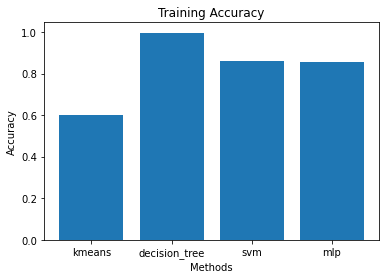

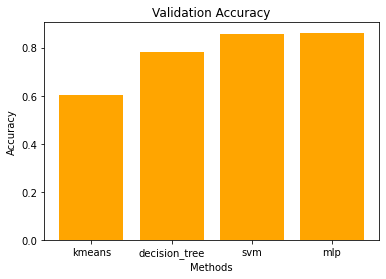

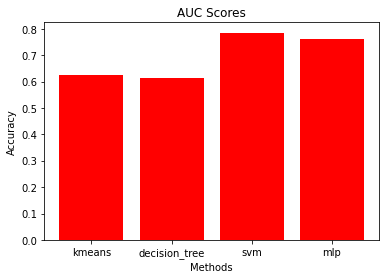

In [11]:
plt.bar(meths, train_acc, label = 'train_acc')
plt.title('Training Accuracy')
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.show()

plt.bar(meths, test_acc, label = 'val_acc', color = 'orange')
plt.title('Validation Accuracy')
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.show()

plt.bar(meths, auc, label = 'auc', color = 'red')
plt.title('AUC Scores')
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.show()

We can conclude that SVM is the best method for this dataset with a highest AUC score of 78%